# Predict for WNV

### Executive Summary

This notebook aims to create models that will predict for the presence of WNV in a given mosquito population. Since WNV is not present 99.6% of the time, the imbalanced classes in our target variable posed our first challenge. As we will come to discover, our model is not sensitive to the presence of WNV and the general predictions from our model result in all negative predictions. From an accuracy stand-point, this may appear good. However, since there are no true positives and only false negatives, we incur Type II errors that are detrimental to our model's effectiveness to identify WNV outbreaks as they happen. As such, the AUC-ROC score is our metric of choice as it takes into account both specificity and recall.

An AUC-ROC score of 0.5 is the worst possible score while an AUC-ROC score of 1.0 is the best possible. As we cross-validate and evaluate our models, we aim to maximise our AUC-ROC score. It is worthwhile to note that the Kaggle submission evaluates our predictions based on the AUC-ROC score of our predicition probabilities, whereas the AUC-ROC score we can evaluate our models on are based on the prediction outcomes (as we have no way of knowing the true prediction probabilities). This means that we can expect our AUC-ROC score on Kaggle to always be worse than our cross-validated AUC-ROC score.

Our baseline model and subsequent models were built using the Logistic Regression algorithm using just two features - Species and Traps. The prediction probabilities for a postive WNV outcome were found to be all less than 0.01. Since a positive WNV outcome will only be given when the probability is greater than 0.5, our model inevitably predicts 100% negative WNV outcomes with a poor AUC-ROC socre of 0.5. As we know this not to be true, we forced the predictions by lowering the threshold for a positive prediction. This was one method to deal with the problem of imbalanced classes. Support Vector Machine (SVM) was also attempted as a possible model, but to poor effect. For SVM, we used bootstrapping to create balanced classes to deal with the problem of imbalanced classes. The AUC-ROC score from SVM was poorer than Logistic Regression, thus we proceed with Logistic Regression for as our final model using our finetuned hyper-parameters.

Using our final model, we derived some insights about the features our model was trained on. Time was the most important feature to consider. This makes sense from our EDA as we see greatest spike in mosquito activity in the months of July and August, suggesting a seasonal pattern in mosquito population through the years. It can be assumed that with a greater mosquito population comes greater opportunities for the spread of WNV. The next most important feature is the species of mosquito. The top 2 carriers of the WNV are the Culex Pipiens and Restuans species.

### Contents
- [Baseline Model](#Baseline-Model)
- [Linear Regression](#Linear-Regression)
- [Support Vector Machine](#Support-Vector-Machine)
- [Analysis from Model](#Analysis-from-Model)
- [Kaggle Submission](#Kaggle-Submission)
- [Conclusions](#Conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
pd.set_option('display.max_columns', 200)

### Baseline Model

After adding in the missing rows/combining the rows capped at 50 mosquitoes, we would like to make a baseline model. This model: 

- Does not use any feature engineered columns (we will add that in later)
- Intended to provide a baseline estimation for how good later models are.

#### Import Modified Training Set
Training set was reshaped to match the shape of the test set in our Preprocessing Notebook.

In [2]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [3]:
train_all = pd.read_csv("../data/train_modified_rows.csv")
train_all.drop("Unnamed: 0", axis = 1, inplace=True)
train_all.head(2)

Address                 Species  \
0  4100 North Oak Park Avenue, Chicago, IL 60634,...  CULEX PIPIENS/RESTUANS   
1  4100 North Oak Park Avenue, Chicago, IL 60634,...          CULEX RESTUANS   

   Block           Street  Trap             AddressNumberAndStreet  Latitude  \
0     41   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469   
1     41   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469   

   Longitude  AddressAccuracy        Date  NumMosquitos  WnvPresent  \
0 -87.800991                9  2007-05-29             1           0   
1 -87.800991                9  2007-05-29             1           0   

   wnv_percent  
0          0.0  
1          0.0

In [4]:
train_all["Date"] = pd.to_datetime(train_all["Date"])

train_all.set_index("Date", inplace=True)

In [5]:
train_all.head()

Address  \
Date                                                            
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                           Species  Block           Street  Trap  \
Date                                                               
2007-05-29  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29           CULEX PIPIENS     41   N OAK PARK AVE  T002   
2007-05-29        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
2007-05-29         CULEX TERRITANS     41   N OAK PARK AVE  T002   

                       AddressNumberAndStreet  Latitude  Longitude  \
Date                                                                 
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   

            AddressAccuracy  NumMosquitos  WnvPresent  wnv_percent  
Date                                                                
2007-05-29                9             1           0          0.0  
2007-05-29                9             1           0          0.0  
2007-05-29                9             0           0          0.0  
2007-05-29                9             0           0          0.0  
2007-05-29                9             0           0          0.0

In [6]:
train_all.columns

Index(['Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'wnv_percent'],
      dtype='object')

In [7]:
# create 4 dataframes, one for each year
train_2007 = train_all["2007"]
train_2009 = pd.concat([train_all["2009"], train_2007], axis = 0)
train_2011 = pd.concat([train_all["2011"], train_2009], axis = 0)
train_2013 = pd.concat([train_all["2013"], train_2011], axis = 0)

#### Baseline Accuracy
The most basic of models: predicting the majority class.

In [8]:
1 - train_all["WnvPresent"].mean()

0.9960177762286511

On average, if we predict that WNV is not present, we will be accurate 99.602% of the time. This is pretty good but not that useful since we want to know where WNV was present. Let's try the auc roc: 

In [9]:
size = train_all.shape[0]
all_no_wnv = np.zeros(size)
roc_auc_score(train_all["WnvPresent"], all_no_wnv)

0.5

An AUC ROC score of 0.5 is the worst possible score, which is what we would expect.

#### Slightly more complicated model on 2007 data
Using logistic regression we can try to predict whether WNV is present:

In [10]:
# For 2007, we train test split it, and see how well it does
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2007.drop(["WnvPresent", "NumMosquitos", "wnv_percent"], axis = 1),
    train_2007["WnvPresent"], shuffle=False)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.

In [12]:
# dummy the vars

def make_dummies(df):

    dummy_species = pd.get_dummies(df["Species"])
    dummy_trap = pd.get_dummies(df["Trap"])
    
    return pd.concat([dummy_species, dummy_trap], axis=1)._get_numeric_data()

In [13]:
# dummy the columns
X_train = make_dummies(X_train)
X_valid = make_dummies(X_valid)

In [14]:
# run through logistic regression
# dont need to scale since it's all one hot

lr = LogisticRegression(penalty="elasticnet", solver="saga")

params = {"C" : np.linspace(0.001, 1, 3),
          "l1_ratio" : np.linspace(0 ,1, 3)}

# grid search for the best parameters using AUC ROC
gridsearcher = GridSearchCV(lr, params, n_jobs = -1, cv= 3, verbose = 1)

In [15]:
gridsearcher.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.6s finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([0.001 , 0.5005, 1.    ]),
                         'l1_ratio': array([0. , 0.5, 1. ])},
             verbose=1)

In [16]:
best_logreg = gridsearcher.best_estimator_
best_logreg

LogisticRegression(C=0.001, l1_ratio=0.0, penalty='elasticnet', solver='saga')

In [17]:
best_logreg.C

0.001

So we are using ridge regression with C = 1

In [18]:
# Score
print(best_logreg.score(X_train, y_train))

print(best_logreg.score(X_valid, y_valid))

0.9940464245100007
0.9988962472406181


In [19]:
predictions = best_logreg.predict(X_valid)
roc_auc_score(y_valid, predictions)

0.5

We can see that the predictions are all of the majority class:

In [20]:
set(predictions)

{0}

In [21]:
# get the probabilities of WNV present
probas = best_logreg.predict_proba(X_valid)

probas = pd.DataFrame(probas).iloc[:,1]
probas

0       0.006409
1       0.005815
2       0.005815
3       0.005815
4       0.005815
          ...   
9961    0.005816
9962    0.005816
9963    0.005816
9964    0.005816
9965    0.005816
Name: 1, Length: 9966, dtype: float64

This means that the model is predicting no WNV for everything, which is essentially not very useful. What we can do, is use predict proba and draw the threshold at something other than 0.5:

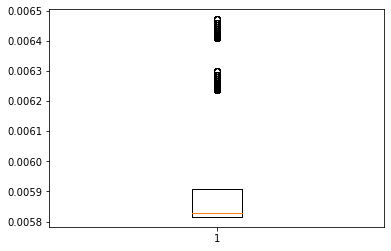

In [22]:
# Plot the dist of predictions
plt.boxplot(probas);

We can see that there are clearly 2 groups, so we want to draw the threshold somewhere else that isn't 0.5

In [23]:
# THis function creates new predictions based on a different threshold
# Threshold is specified by standard deviations of the training data of the probabilities
def re_predict_std(list_probas, std):
    re_predict = (list_probas > (list_probas.mean() + (std*list_probas.std()))).astype(int)
    return re_predict

In [24]:
re_predict_2007 = re_predict_std(list_probas=probas, std=1)

Now, run the AUC ROC again to see how well we did

In [25]:
roc_auc_score(y_valid, re_predict_2007)

0.8754394776494224

We can see that the model is predicting better.

#### Repeat for 2009 data
Note that for 2009 dataset, it is actually the data for 2007, and 2009 combined. No 2011 and 2013 data to prevent data leakage.

In [26]:
# split into train test
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2009.drop(["WnvPresent", "NumMosquitos", "wnv_percent"], axis = 1),
    train_2009["WnvPresent"], shuffle=False)

In [27]:
# get only the columns we want
X_train = make_dummies(X_train)
X_valid = make_dummies(X_valid)

In [28]:
# fit model to this new thing
gridsearcher.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.4s finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([0.001 , 0.5005, 1.    ]),
                         'l1_ratio': array([0. , 0.5, 1. ])},
             verbose=1)

In [29]:
best_logreg = gridsearcher.best_estimator_
best_logreg

LogisticRegression(C=0.001, l1_ratio=0.0, penalty='elasticnet', solver='saga')

In [30]:
predictions = best_logreg.predict(X_valid)
roc_auc_score(y_valid, predictions)

0.5

Once again, it doesn't work with the base predictions. Howevre, if we change the threshold:

In [31]:
# Get probabilities then use a different threshold to classify
probas = best_logreg.predict_proba(X_valid)
probas = pd.DataFrame(probas).iloc[:,1]
re_predict_2009 = re_predict_std(list_probas=probas, std=1)
roc_auc_score(y_valid, re_predict_2009)

0.8729544926312001

We see that it worked better, again.

#### Repeat for 2011 data
Note that for 2011 dataset it is actually the data for 2007, 2009, and 2011 combined. No 2013 data to prevent data leakage.

In [32]:
# split into train test
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2011.drop(["WnvPresent", "NumMosquitos", "wnv_percent"], axis = 1),
    train_2011["WnvPresent"], shuffle=False)

# get only the columns we want
X_train = make_dummies(X_train)
X_valid = make_dummies(X_valid)

# fit model
gridsearcher.fit(X_train, y_train)

# get best model
best_logreg = gridsearcher.best_estimator_

print(best_logreg)

# change threshold
probas = best_logreg.predict_proba(X_valid)
probas = pd.DataFrame(probas).iloc[:,1]
re_predict_2011 = re_predict_std(list_probas=probas, std=1)
roc_auc_score(y_valid, re_predict_2011)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    7.1s finished


LogisticRegression(C=0.001, l1_ratio=0.0, penalty='elasticnet', solver='saga')


0.6262667084731826

The AUC ROC is less, most likely because of spraying efforts that mean our model is inaccurate.

#### Repeat for 2013 data
Note that for 2013 dataset it is actually the data for 2007, 2009, 2011, and 2013 combined.

In [33]:
# split into train test
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2013.drop(["WnvPresent", "NumMosquitos", "wnv_percent"], axis = 1),
    train_2013["WnvPresent"], shuffle=False)

# get only the columns we want
X_train = make_dummies(X_train)
X_valid = make_dummies(X_valid)

# fit model
gridsearcher.fit(X_train, y_train)

# get best model
best_logreg = gridsearcher.best_estimator_

print(best_logreg)

# change threshold
probas = best_logreg.predict_proba(X_valid)
probas = pd.DataFrame(probas).iloc[:,1]
re_predict_2013 = re_predict_std(list_probas=probas, std=1)
roc_auc_score(y_valid, re_predict_2013)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    9.3s finished


LogisticRegression(C=0.001, l1_ratio=0.0, penalty='elasticnet', solver='saga')


0.6364773553758915

Once again the score isn't as good because 2013 had a lot of spraying. This is just modelled on the basic data so it doesn't take the spraying into account. Because this year has a lot of spraying I want to see what the distributions look like.

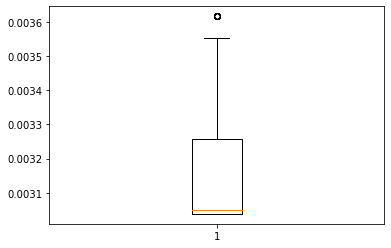

In [34]:
plt.boxplot(probas);

#### Baseline Model - Compounded Years Training Sets

In [129]:
# methodology revolves around maximising training data available for use
# in order to prevent data leakage in time-series data:
### data from 2007 is used to predict for 2008
### data from 2007, 2009 is used to predict for 2010
### data from 2007, 2009, 2011 is used to predict for 2012
### data from 2007, 2009, 2011, 2013 is used to predict for 2014

In [130]:
def kaggle_baseline_proba(df_train, target, df_test, estimator):
    model = estimator
    df_train_dumm = dummy_species_trap(df_train) # get dummies as baseline predictors
    model.fit(df_train_dumm, df_train[target])
    df_test_dumm = dummy_species_trap(df_test) # get dummies as baseline predictors
    probas = model.predict_proba(df_test_dumm)
    probas = pd.DataFrame(probas)[1] # extract probabilities of positive predictions
    probas = scale_1D_probas(probas) # scale
    df_kaggle = pd.DataFrame(zip(df_test["Id"], probas), columns=["Id", "WnvPresent"])
    return df_kaggle

In [131]:
# create dataframes of predictions
df_kaggle_2008 = kaggle_baseline_proba(df_train=train_2007, target="WnvPresent", df_test=test_2008,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))
df_kaggle_2010 = kaggle_baseline_proba(df_train=train_2009, target="WnvPresent", df_test=test_2010,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))
df_kaggle_2012 = kaggle_baseline_proba(df_train=train_2011, target="WnvPresent", df_test=test_2012,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))
df_kaggle_2014 = kaggle_baseline_proba(df_train=train_2013, target="WnvPresent", df_test=test_2014,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))

# concat all predictions into one df for Kaggle submission
df_kaggle = pd.concat([df_kaggle_2008, df_kaggle_2010, df_kaggle_2012, df_kaggle_2014]).reset_index(drop=True)
df_kaggle.shape

(116293, 2)

In [132]:
df_kaggle.describe()

Id     WnvPresent
count  116293.000000  116293.000000
mean    58147.000000       0.228288
std     33571.041765       0.338867
min         1.000000       0.000000
25%     29074.000000       0.000000
50%     58147.000000       0.027130
75%     87220.000000       0.612744
max    116293.000000       1.000000

In [133]:
df_kaggle.to_csv("../data/kaggle_model_01a.csv", index=False)

![](../assets/kaggle_model_01a.png)

In [134]:
# Kaggle gave an ROC-AUC score of 0.670

#### Baseline Model - Paired Training and Test Sets

In [135]:
# methodology revolves around pairing training data with the test data the year after
# in order to prevent data leakage in time-series data:
### data from 2007 is used to predict for 2008
### data from 2009 is used to predict for 2010
### data from 2011 is used to predict for 2012
### data from 2013 is used to predict for 2014

In [136]:
# create dataframes of predictions
df_kaggle_2008 = kaggle_baseline_proba(df_train=df["2007"], target="WnvPresent", df_test=test_2008,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))
df_kaggle_2010 = kaggle_baseline_proba(df_train=df["2009"], target="WnvPresent", df_test=test_2010,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))
df_kaggle_2012 = kaggle_baseline_proba(df_train=df["2011"], target="WnvPresent", df_test=test_2012,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))
df_kaggle_2014 = kaggle_baseline_proba(df_train=df["2013"], target="WnvPresent", df_test=test_2014,
                                       estimator=LogisticRegression(penalty="l2", solver="liblinear", C=0.001))

# concat all predictions into one df for Kaggle submission
df_kaggle = pd.concat([df_kaggle_2008, df_kaggle_2010, df_kaggle_2012, df_kaggle_2014]).reset_index(drop=True)
df_kaggle.shape

(116293, 2)

In [137]:
df_kaggle.describe()

Id     WnvPresent
count  116293.000000  116293.000000
mean    58147.000000       0.183892
std     33571.041765       0.298667
min         1.000000       0.000000
25%     29074.000000       0.000000
50%     58147.000000       0.010001
75%     87220.000000       0.222330
max    116293.000000       1.000000

In [138]:
df_kaggle.to_csv("../data/kaggle_model_01b.csv", index=False)

![](../assets/kaggle_model_01b.png)

In [139]:
# Kaggle gave an ROC-AUC score of 0.648

#### Baseline Model Conclusions:
The accuracy/auc_roc of the model decreases significantly because of spraying. This means we should definitely take that into account for later models. It also establishes a baseline score for years with/without spraying.

Since the Kaggle predictions are for years where there were no spraying (according to the spray data we have), we will drop the rows that correspond with the spray locations for each year to prevent the skewing of our data from the effect of the spray. Finally, we will also predict for each year using the compounded data of all years before year-to-predict.

---

### Linear Regression

#### Import Modified Training Set combined with outside Features
Taking the cleaned/feature engineered data from the EDA we can create more accurate models.

In [35]:
train_df_updated = pd.read_csv("../data/train_modified_rows_combined.csv")

In [36]:
# extra cols with no meaning
train_df_updated.drop(["Unnamed: 0", "index"], inplace=True, axis = 1)

In [37]:
train_df_updated.head(2)

Address  Block           Street  \
0  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   N OAK PARK AVE   
1  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   N OAK PARK AVE   

   Trap             AddressNumberAndStreet  Latitude  Longitude  \
0  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
1  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   

   AddressAccuracy        Date  NumMosquitos  WnvPresent  wnv_percent  Year  \
0                9  2007-05-29             1           0          0.0  2007   
1                9  2007-05-29             1           0          0.0  2007   

   Month  Day          Unix  after_spray  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
0      5   29  1.180368e+09            0  88.0  62.5  75.5      58.5     65.5   
1      5   29  1.180368e+09            0  88.0  62.5  75.5      58.5     65.5   

   SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
0       0.0          0.0      6.95                        0   
1       0.0          0.0      6.95                        0   

   Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                               0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                       0                         0                       0   
1                       1                         0                       0   

   Species_CULEX TERRITANS  Species_UNSPECIFIED CULEX  
0                        0                          0  
1                        0                          0

As mentioned above we will drop the traps which were measured after spraying:

In [38]:
# rows after spraying
train_df_updated["after_spray"].value_counts()

0    113984
1       776
Name: after_spray, dtype: int64

In [39]:
# only get ones that were unsprayed
train_df_updated = train_df_updated[train_df_updated["after_spray"] == 0]

In [40]:
train_df_updated["after_spray"].value_counts()

0    113984
Name: after_spray, dtype: int64

Next, dummy the traps.

In [41]:
# 
train_df_updated = pd.concat([train_df_updated,
                              pd.get_dummies(train_df_updated["Trap"])], axis = 1)

train_df_updated.head(2)

Address  Block           Street  \
0  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   N OAK PARK AVE   
1  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   N OAK PARK AVE   

   Trap             AddressNumberAndStreet  Latitude  Longitude  \
0  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
1  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   

   AddressAccuracy        Date  NumMosquitos  WnvPresent  wnv_percent  Year  \
0                9  2007-05-29             1           0          0.0  2007   
1                9  2007-05-29             1           0          0.0  2007   

   Month  Day          Unix  after_spray  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
0      5   29  1.180368e+09            0  88.0  62.5  75.5      58.5     65.5   
1      5   29  1.180368e+09            0  88.0  62.5  75.5      58.5     65.5   

   SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
0       0.0          0.0      6.95                        0   
1       0.0          0.0      6.95                        0   

   Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                               0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                       0                         0                       0   
1                       1                         0                       0   

   Species_CULEX TERRITANS  Species_UNSPECIFIED CULEX  T001  T002  T002A  \
0                        0                          0     0     1      0   
1                        0                          0     0     1      0   

   T002B  T003  T004  T005  T006  T007  T008  T009  T009a  T011  T012  T013  \
0      0     0     0     0     0     0     0     0      0     0     0     0   
1      0     0     0     0     0     0     0     0      0     0     0     0   

   T014  T015  T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   T034  T035  T035a  T036  T037  T039  T040  T043  T044  T045  T046  T047  \
0     0     0      0     0     0     0     0     0     0     0     0     0   
1     0     0      0     0     0     0     0     0     0     0     0     0   

   T048  T049  T050  T051  T054  T054C  T060  T061  T062  T063  T065  T065A  \
0     0     0     0     0     0      0     0     0     0     0     0      0   
1     0     0     0     0     0      0     0     0     0     0     0      0   

   T066  T067  T069  T070  T071  T072  T073  T074  T075  T076  T077  T078  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   T079  T080  T081  T082  T083  T084  T085  T086  T088  T089  T090  T090A  \
0     0     0     0     0     0     0     0     0     0     0     0      0   
1     0     0     0     0     0     0     0     0     0     0     0      0   

   T090B  T090C  T091  T092  T094  T094B  T095  T096  T097  T099  T100  T102  \
0      0      0     0     0     0      0     0     0     0     0     0     0   
1      0      0     0     0     0      0     0     0     0     0     0     0   

   T103  T107  T114  T115  T128  T128A  T129  T135  T138  T141  T142  T143  \
0     0     0     0     0     0      0     0     0     0     0     0     0   
1     0     0     0     0     0      0     0     0     0     0     0     0   

   T144  T145  T146  T147  T148  T149  T150  T151  T152  T153  T154  T155  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   T156  T157  T158  T159  T160  T161  T162  T200  T200A  T200B  T206  T209  \
0     0     0     0     0     0     0     0     0      0      0     0     0   
1     

#### A little bit of feature engineering
Most of the features can be used as is, except for the time. I will just convert the Unix time to "seconds after the start of the year" so that we have the same baseline for each year.

In [42]:
import datetime
import time

In [43]:
# for each year in the list
# get the unix time at Jan 1 midnight
# put into a dictionary
year_to_unix = {}
for i in range(2007, 2015):
    # first day of the year
    d = datetime.date(i, 1, 1)
    
    # covert into unix time
    unixtime = time.mktime(d.timetuple())
    
    # add this to the dictionary
    year_to_unix[i] = unixtime


# use this in an apply to add a new column
def secs_after_year_start(row):
    # get the year
    year = row["Year"]
    
    # get the number of seconds past the start of the year
    seconds_after_year_start = row["Unix"] - year_to_unix[year]
    
    row["secs_after_jan1"] = seconds_after_year_start
    
    return row

In [44]:
%%time
train_df_updated = train_df_updated.apply(secs_after_year_start, axis = 1)

Wall time: 1min 17s


In [46]:
# check it worked
train_df_updated.head(2)

Address  Block           Street  \
0  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   N OAK PARK AVE   
1  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   N OAK PARK AVE   

   Trap             AddressNumberAndStreet  Latitude  Longitude  \
0  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
1  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   

   AddressAccuracy        Date  NumMosquitos  WnvPresent  wnv_percent  Year  \
0                9  2007-05-29             1           0          0.0  2007   
1                9  2007-05-29             1           0          0.0  2007   

   Month  Day          Unix  after_spray  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
0      5   29  1.180368e+09            0  88.0  62.5  75.5      58.5     65.5   
1      5   29  1.180368e+09            0  88.0  62.5  75.5      58.5     65.5   

   SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
0       0.0          0.0      6.95                        0   
1       0.0          0.0      6.95                        0   

   Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                               0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                       0                         0                       0   
1                       1                         0                       0   

   Species_CULEX TERRITANS  Species_UNSPECIFIED CULEX  T001  T002  T002A  \
0                        0                          0     0     1      0   
1                        0                          0     0     1      0   

   T002B  T003  T004  T005  T006  T007  T008  T009  T009a  T011  T012  T013  \
0      0     0     0     0     0     0     0     0      0     0     0     0   
1      0     0     0     0     0     0     0     0      0     0     0     0   

   T014  T015  T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   T034  T035  T035a  T036  T037  T039  T040  T043  T044  T045  T046  T047  \
0     0     0      0     0     0     0     0     0     0     0     0     0   
1     0     0      0     0     0     0     0     0     0     0     0     0   

   T048  T049  T050  T051  T054  T054C  T060  T061  T062  T063  T065  T065A  \
0     0     0     0     0     0      0     0     0     0     0     0      0   
1     0     0     0     0     0      0     0     0     0     0     0      0   

   T066  T067  T069  T070  T071  T072  T073  T074  T075  T076  T077  T078  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   T079  T080  T081  T082  T083  T084  T085  T086  T088  T089  T090  T090A  \
0     0     0     0     0     0     0     0     0     0     0     0      0   
1     0     0     0     0     0     0     0     0     0     0     0      0   

   T090B  T090C  T091  T092  T094  T094B  T095  T096  T097  T099  T100  T102  \
0      0      0     0     0     0      0     0     0     0     0     0     0   
1      0      0     0     0     0      0     0     0     0     0     0     0   

   T103  T107  T114  T115  T128  T128A  T129  T135  T138  T141  T142  T143  \
0     0     0     0     0     0      0     0     0     0     0     0     0   
1     0     0     0     0     0      0     0     0     0     0     0     0   

   T144  T145  T146  T147  T148  T149  T150  T151  T152  T153  T154  T155  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   

   T156  T157  T158  T159  T160  T161  T162  T200  T200A  T200B  T206  T209  \
0     0     0     0     0     0     0     0     0      0      0     0     0   
1     

Split the data into the 4 dataframes, for the years:
- 2007
- 2007 and 2009
- 2007, 2009, 2011,
- 2017, 2009, 2011, and 2013 (everything)

In [47]:
# First , change the date to the index so we can filter by it
train_df_updated["Date"] = pd.to_datetime(train_df_updated["Date"])
train_df_updated.set_index("Date", inplace=True)

In [48]:
# make sure it works
train_df_updated.head(2)

Address  Block  \
Date                                                                   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   

                     Street  Trap             AddressNumberAndStreet  \
Date                                                                   
2007-05-29   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL   
2007-05-29   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL   

            Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent  \
Date                                                                         
2007-05-29  41.95469 -87.800991                9             1           0   
2007-05-29  41.95469 -87.800991                9             1           0   

            wnv_percent  Year  Month  Day          Unix  after_spray  Tmax  \
Date                                                                         
2007-05-29          0.0  2007      5   29  1.180368e+09            0  88.0   
2007-05-29          0.0  2007      5   29  1.180368e+09            0  88.0   

            Tmin  Tavg  DewPoint  WetBulb  SnowFall  PrecipTotal  AvgSpeed  \
Date                                                                         
2007-05-29  62.5  75.5      58.5     65.5       0.0          0.0      6.95   
2007-05-29  62.5  75.5      58.5     65.5       0.0          0.0      6.95   

            Species_CULEX ERRATICUS  Species_CULEX PIPIENS  \
Date                                                         
2007-05-29                        0                      0   
2007-05-29                        0                      0   

            Species_CULEX PIPIENS/RESTUANS  Species_CULEX RESTUANS  \
Date                                                                 
2007-05-29                               1                       0   
2007-05-29                               0                       1   

            Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
Date                                                           
2007-05-29                         0                       0   
2007-05-29                         0                       0   

            Species_CULEX TERRITANS  Species_UNSPECIFIED CULEX  T001  T002  \
Date                                                                         
2007-05-29                        0                          0     0     1   
2007-05-29                        0                          0     0     1   

            T002A  T002B  T003  T004  T005  T006  T007  T008  T009  T009a  \
Date                                                                        
2007-05-29      0      0     0     0     0     0     0     0     0      0   
2007-05-29      0      0     0     0     0     0     0     0     0      0   

            T011  T012  T013  T014  T015  T016  T017  T018  T019  T025  T027  \
Date                                                                           
2007-05-29     0     0     0     0     0     0     0     0     0     0     0   
2007-05-29     0     0     0     0     0     0     0     0     0     0     0   

            T028  T030  T031  T033  T034  T035  T035a  T036  T037  T039  T040  \
Date                                                                            
2007-05-29     0     0     0     0     0     0      0     0     0     0     0   
2007-05-29     0     0     0     0     0     0      0     0     0     0     0   

            T043  T044  T045  T046  T047  T048  T049  T050  T051  T054  T054C  \
Date                                                                            
2007-05-29     0     0     0     0     0     0     0     0     0     0      0   
2007-05-29     0     0     0     0     0     0     0     0     0     0      0   

            T060  T061  T062  T063  T065  T065A  T066  T067  T069  T070  T071  \
Date                                                                        

In [49]:
# create 4 dataframes, one for each year
train_2007 = train_df_updated["2007"]
train_2009 = pd.concat([train_df_updated["2009"], train_2007], axis = 0)
train_2011 = pd.concat([train_df_updated["2011"], train_2009], axis = 0)
train_2013 = pd.concat([train_df_updated["2013"], train_2011], axis = 0)

At this stage, we have done the following:
- Feature engineered some columns, notably the weather, the time, the mosquito species, and the trap
- Divided the data into 4 separate dataframes, one for 2007, one for 2007 & 2009 .etc

Now, for the 2007 data, split it into train and validation sets. Also drop some columns:

#### More complicated model on 2007 data
Using logistic regression we can predict whether WNV is present:

In [55]:
# Drop some other things that I forgot to drop above, that are not needed/available in test data
# Also drop the year/month/day since we already have it as seconds past Jan1
# I don't think lat/longitude do anything but I'll just leave it in there
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2007.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2007["WnvPresent"], shuffle=False)

In [56]:
# Take a look at the data
X_train.tail(3)

Address  Block  \
Date                                                                   
2007-09-05    5800 North Pulaski Road, Chicago, IL 60646, USA     58   
2007-09-05  6600 South Kilpatrick Avenue, Chicago, IL 6062...     66   
2007-09-05  6600 South Kilpatrick Avenue, Chicago, IL 6062...     66   

                       Street  Trap               AddressNumberAndStreet  \
Date                                                                       
2007-09-05       N PULASKI RD  T027      5800  N PULASKI RD, Chicago, IL   
2007-09-05   S KILPATRICK AVE  T156  6600  S KILPATRICK AVE, Chicago, IL   
2007-09-05   S KILPATRICK AVE  T156  6600  S KILPATRICK AVE, Chicago, IL   

             Latitude  Longitude  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
Date                                                                    
2007-09-05  41.984809 -87.728492  90.5  69.0  80.0      62.5     69.0   
2007-09-05  41.772846 -87.740029  90.5  69.0  80.0      62.5     69.0   
2007-09-05  41.772846 -87.740029  90.5  69.0  80.0      62.5     69.0   

            SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
Date                                                                   
2007-09-05       0.0       0.0005       6.6                        1   
2007-09-05       0.0       0.0005       6.6                        0   
2007-09-05       0.0       0.0005       6.6                        0   

            Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2007-09-05                      0                               0   
2007-09-05                      0                               1   
2007-09-05                      0                               0   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2007-09-05                       0                         0   
2007-09-05                       0                         0   
2007-09-05                       1                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  \
Date                                                          
2007-09-05                       0                        0   
2007-09-05                       0                        0   
2007-09-05                       0                        0   

            Species_UNSPECIFIED CULEX  T001  T002  T002A  T002B  T003  T004  \
Date                                                                          
2007-09-05                          0     0     0      0      0     0     0   
2007-09-05                          0     0     0      0      0     0     0   
2007-09-05                          0     0     0      0      0     0     0   

            T005  T006  T007  T008  T009  T009a  T011  T012  T013  T014  T015  \
Date                                                                            
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   

            T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  T034  \
Date                                                                           
2007-09-05     0     0     0     0     0     1     0     0     0     0     0   
2007-09-05     0     0     0     0     0     0     0     0     0     0     0   
2007-09-05     0     0     0     0     0     0     0     0     0     0     0   

            T035  T035a  T036  T037  T039  T040  T043  T044  T045  T046  T047  \
Date                                                                            
2007-09-05     0      0     0     0     0     0     0     0     0     0     0   
2007-09-05     0      0     0     0     0     0     0     0     0     0     0   
2007-09-05     0      0     0     0     0     0     0     0     0     0    

In [57]:
X_valid.head(2)

Address  Block  \
Date                                                                   
2007-09-05  6600 South Kilpatrick Avenue, Chicago, IL 6062...     66   
2007-09-05  6600 South Kilpatrick Avenue, Chicago, IL 6062...     66   

                       Street  Trap               AddressNumberAndStreet  \
Date                                                                       
2007-09-05   S KILPATRICK AVE  T156  6600  S KILPATRICK AVE, Chicago, IL   
2007-09-05   S KILPATRICK AVE  T156  6600  S KILPATRICK AVE, Chicago, IL   

             Latitude  Longitude  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
Date                                                                    
2007-09-05  41.772846 -87.740029  90.5  69.0  80.0      62.5     69.0   
2007-09-05  41.772846 -87.740029  90.5  69.0  80.0      62.5     69.0   

            SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
Date                                                                   
2007-09-05       0.0       0.0005       6.6                        0   
2007-09-05       0.0       0.0005       6.6                        0   

            Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2007-09-05                      1                               0   
2007-09-05                      0                               0   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2007-09-05                       0                         0   
2007-09-05                       0                         1   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  \
Date                                                          
2007-09-05                       0                        0   
2007-09-05                       0                        0   

            Species_UNSPECIFIED CULEX  T001  T002  T002A  T002B  T003  T004  \
Date                                                                          
2007-09-05                          0     0     0      0      0     0     0   
2007-09-05                          0     0     0      0      0     0     0   

            T005  T006  T007  T008  T009  T009a  T011  T012  T013  T014  T015  \
Date                                                                            
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   

            T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  T034  \
Date                                                                           
2007-09-05     0     0     0     0     0     0     0     0     0     0     0   
2007-09-05     0     0     0     0     0     0     0     0     0     0     0   

            T035  T035a  T036  T037  T039  T040  T043  T044  T045  T046  T047  \
Date                                                                            
2007-09-05     0      0     0     0     0     0     0     0     0     0     0   
2007-09-05     0      0     0     0     0     0     0     0     0     0     0   

            T048  T049  T050  T051  T054  T054C  T060  T061  T062  T063  T065  \
Date                                                                            
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   
2007-09-05     0     0     0     0     0      0     0     0     0     0     0   

            T065A  T066  T067  T069  T070  T071  T072  T073  T074  T075  T076  \
Date                                                                            
2007-09-05      0     0     0     0     0     0     0     0     0     0     0   
2007-09-05      0     0     0     0     0     0     0     0     0     0     0   

            T077  T078  T079  T080  T081  T082  T083  T084  T085  T086  T088  \
Date                                                                     

In [58]:
X_train.columns

Index(['Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg',
       ...
       'T232', 'T233', 'T234', 'T235', 'T236', 'T237', 'T238', 'T900', 'T903',
       'secs_after_jan1'],
      dtype='object', length=175)

For the 2007 data, try a few models. However, we first need to establish a pipeline that does the following:
- Removes non-numerical columns
- Standard scales the data
- Attempts some kind of classification model such as KNN, Naive Bayes.etc

After that we will changge the threshold for 'positive' to 1 standard deviation above the mean probability (what we did earlier).

First, try Logistic Regression as before

In [59]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [60]:
# wrapper so that I can pass it into a pipeline
class OnlyNumeric:
    def __init__(self):
        pass
    def fit(self, df, y):
        return self
        
    def transform(self, df):
        return df._get_numeric_data()


# create pipeline
steps = [("numeric", OnlyNumeric()),
         ("scale", StandardScaler()),
         ("logreg", LogisticRegression(max_iter = 10000))]

logistic_pipeline = Pipeline(steps)

In [61]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A1C86E20>),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=10000))])

See how well this pipeline does for 2007:

In [62]:
preds_2007 = re_predict_std(logistic_pipeline.predict_proba(X_valid)[:,1], 1)

In [63]:
roc_auc_score(y_valid, preds_2007)

0.7089402310396786

We can see that it is working ok, so we should try to find the optimal hyperparameters:

In [64]:
params = {"logreg__C" : np.linspace(0.001, 1, 3),
          "logreg__l1_ratio" : np.linspace(0 ,1, 3),
          "logreg__penalty" : ["elasticnet"],
          "logreg__solver" : ["saga"]}


# lr = LogisticRegression(penalty="elasticnet", solver="saga")
# grid search for the best parameters
gridsearcher = GridSearchCV(logistic_pipeline, params, n_jobs = -1, cv= 3, verbose = 1, scoring="roc_auc")

In [65]:
gridsearcher.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   43.8s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('numeric',
                                        <__main__.OnlyNumeric object at 0x00000278A1C86E20>),
                                       ('scale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([0.001 , 0.5005, 1.    ]),
                         'logreg__l1_ratio': array([0. , 0.5, 1. ]),
                         'logreg__penalty': ['elasticnet'],
                         'logreg__solver': ['saga']},
             scoring='roc_auc', verbose=1)

In [66]:
gridsearcher.best_estimator_

Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A0B98880>),
                ('scale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.5005, l1_ratio=0.0, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])

Finally, we want to change the threshold value for the probabilities, but we decided to try this method instead. It just scales all the values from 0 to 1, which is better than the earlier method of using a set standard deviation.

In [67]:
from sklearn.preprocessing import MinMaxScaler
def scale_1D_probas(list_probas):
    scaler = MinMaxScaler()
    probas_scaled = scaler.fit_transform(list_probas.reshape(-1,1)) # reshape because method expects 2D array
    return [val[0] for val in probas_scaled] # reshape array of arrays to list

In [68]:
#Get the auc roc score:
print("roc auc before using our custom threshold function")
print(roc_auc_score(y_valid, gridsearcher.predict(X_valid)))

print("roc auc after using the function")
preds_2007 = scale_1D_probas(logistic_pipeline.predict_proba(X_valid)[:,1])
print(roc_auc_score(y_valid, preds_2007))

roc auc before using our custom threshold function
0.49849321948769465
roc auc after using the function
0.9252088945710241


Once again it turns out the linear regression has used a l2 model (ridge), so we can try to use these hyperparameters in the future instead of searching each time. It seems that this new type of scaling the probabilities works better too.

Next, repeat this process for the 3 remaining years. 2009 first:

#### Repeat for 2009 data
Note that for 2009 dataset, it is actually the data for 2007, and 2009 combined. No 2011 and 2013 data to prevent data leakage.

In [70]:
# split into train test
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2009.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2009["WnvPresent"], shuffle=False)

In [71]:
# set up model and run it

# now just use L2 regularization but try different values of C near what we found
params = {"logreg__C" : np.linspace(0.3, 0.8, 5),
          "logreg__penalty" : ["l2"]}


gridsearcher = GridSearchCV(logistic_pipeline, params, n_jobs = -1, cv= 3, verbose = 1, scoring="roc_auc")

In [72]:
gridsearcher.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    4.5s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.6s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('numeric',
                                        <__main__.OnlyNumeric object at 0x00000278A1C86E20>),
                                       ('scale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([0.3  , 0.425, 0.55 , 0.675, 0.8  ]),
                         'logreg__penalty': ['l2']},
             scoring='roc_auc', verbose=1)

In [73]:
gridsearcher.best_estimator_

Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A1C14B50>),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(C=0.3, max_iter=10000))])

In [74]:
# See how well we did
print("roc auc before using our custom threshold function")
print(roc_auc_score(y_valid, gridsearcher.predict(X_valid)))

print("roc auc after using the function")
preds_2009 = scale_1D_probas(logistic_pipeline.predict_proba(X_valid)[:,1])
print(roc_auc_score(y_valid, preds_2009))

roc auc before using our custom threshold function
0.5
roc auc after using the function
0.9678486903104717


It seems a bit suspiciously accurate but we will check the next 2 years and see what it returns:

#### Repeat for 2011 data
Note that for 2011 dataset, it is actually the data for 2007, 2009, and 2011 combined. No 2013 data to prevent data leakage.

In [75]:
# split into train test
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2011.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2011["WnvPresent"], shuffle=False)

In [76]:
# try different params
params = {"logreg__C" : np.linspace(0.2, 0.4, 5),
          "logreg__penalty" : ["l2"]}

gridsearcher = GridSearchCV(logistic_pipeline, params, n_jobs = -1, cv= 3, verbose = 1, scoring="roc_auc")

In [77]:
gridsearcher.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.9s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('numeric',
                                        <__main__.OnlyNumeric object at 0x00000278A1C86E20>),
                                       ('scale', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
                         'logreg__penalty': ['l2']},
             scoring='roc_auc', verbose=1)

In [78]:
gridsearcher.best_estimator_

Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A0B98610>),
                ('scale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.30000000000000004, max_iter=10000))])

In [79]:
# See how well we did
print("roc auc before using our custom threshold function")
print(roc_auc_score(y_valid, gridsearcher.predict(X_valid)))

print("roc auc after using the function")
preds_2011 = scale_1D_probas(logistic_pipeline.predict_proba(X_valid)[:,1])
print(roc_auc_score(y_valid, preds_2011))

roc auc before using our custom threshold function
0.4999783296493737
roc auc after using the function
0.9703469547360206



This is good, it shows that we were able to remove the effect of the sprayed years since our AUC ROC is high. However it still seems a bit suspicious because AUC ROC is so high...

#### Repeat for 2013 data
Note that for 2013 dataset, it is actually the data for 2007, 2009, 2011, and 2013 combined.

In [81]:
# split into train test
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2013.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2013["WnvPresent"], shuffle=False)

In [82]:
# Just use the best params from earlier
params = {"logreg__C" : [0.4],
          "logreg__penalty" : ["l2"]}

gridsearcher = GridSearchCV(logistic_pipeline, params, n_jobs = -1, cv= 3, verbose = 1, scoring="roc_auc")

In [83]:
gridsearcher.fit(X_train, y_train)
print(gridsearcher.best_estimator_)

# See how well we did
print("roc auc before using our custom threshold function")
print(roc_auc_score(y_valid, gridsearcher.predict(X_valid)))

print("roc auc after using the function")
preds_2013 = scale_1D_probas(logistic_pipeline.predict_proba(X_valid)[:,1])
print(roc_auc_score(y_valid, preds_2013))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A0AFE400>),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(C=0.4, max_iter=10000))])
roc auc before using our custom threshold function
0.49982338396326387
roc auc after using the function
0.9713409145292328


To be honest the results seem very accurate so let's try a different model to see how well it works:

---

### Support Vector Machine
Once again create a pipeline.etc for 2007

In [84]:
from sklearn.svm import SVC

In [85]:
# create pipeline for Naive Bayes
# There isn't anything to grid search so I didn't bother with that
steps = [("numeric", OnlyNumeric()),
         ("scale", StandardScaler()),
         ("svc", SVC())]

svc_pipe = Pipeline(steps)

In [87]:
# split into train test for 2007 again
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2007.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2007["WnvPresent"], shuffle=False)

In [88]:
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A1C233D0>),
                ('scale', StandardScaler()), ('svc', SVC())])

In [89]:
# See how well we did
print("roc auc before using our custom threshold function")
print(roc_auc_score(y_valid, svc_pipe.predict(X_valid)))

roc auc before using our custom threshold function
0.5


In this case we cannot adjust the threshold due to SVMs only predicting either 1 or 0. Therefore we will need a better way to handle the case of imbalanced classes. Define a function that takes in our training data (both X and y) and returns a bootstrapped version with equal class weights:

In [90]:
def bootstrap(X_train, y_train):
    
    # first, combine the 2 dataframes
    # it's ugly but it works and I don't have time
    combined = pd.concat([X_train, y_train], axis = 1)
    
    # get only the rows which have WNV positive
    only_wnv = combined[combined["WnvPresent"] == 1]
    
    # see how many have wnv and how many don't
    has_wnv = (combined["WnvPresent"] == 1).sum()
    doesnt_have_wnv = combined.shape[0] - has_wnv
    
    # how many rows we need to sample to get a 50/50 split
    difference = doesnt_have_wnv - has_wnv
    
    # sample these rows
    bootstrapped_rows = only_wnv.sample(n=difference, replace=True)
    
    # concatenate the rows to the original dataframe
    combined = pd.concat([combined, bootstrapped_rows], axis = 0)
    
    # return the modified X_train and y_train
    return (combined.drop(["WnvPresent"], axis = 1), combined["WnvPresent"])

In [91]:
bootstrap(X_train, y_train)[1].value_counts()

1    29720
0    29720
Name: WnvPresent, dtype: int64

Now, run the SVM again with the new balanced classes:

In [92]:
# split into train test for 2007 again
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2007.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2007["WnvPresent"], shuffle=False)

In [93]:
X_train, y_train = bootstrap(X_train, y_train)

In [94]:
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A1C233D0>),
                ('scale', StandardScaler()), ('svc', SVC())])

In [95]:
# See the score for the validation data
print(roc_auc_score(y_valid, svc_pipe.predict(X_valid)))

0.666800602712205


This is better than before but not as good as logistic regression. Nevertheless, try all the other years:

#### Repeat for 2009 data
Note that for 2009 dataset, it is actually the data for 2007, and 2009 combined. No 2011 and 2013 data to prevent data leakage.

In [96]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2009.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2009["WnvPresent"], shuffle=False)

In [97]:
# boostrap
X_train, y_train = bootstrap(X_train, y_train)

In [98]:
# use SVC
svc_pipe.fit(X_train, y_train)

print("roc auc score:")
print(roc_auc_score(y_valid, svc_pipe.predict(X_valid)))

roc auc score:
0.7655457060527375


It appears to be working better due to having more data.

#### Repeat for 2011 and 2013
Because this is getting way too long. Also note: This takes **forever** to run, so I commented the fit sections out. If you really need it, uncomment them.

In [ ]:
########
# 2011 #
########
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2011.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2011["WnvPresent"], shuffle=False)

# boostrap
X_train, y_train = bootstrap(X_train, y_train)

# UNCOMMENT TO RUN
# svc_pipe.fit(X_train, y_train)
# print("roc auc score for 2011:")
# print(roc_auc_score(y_valid, svc_pipe.predict(X_valid)))

########
# 2013 #
########
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2013.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2013["WnvPresent"], shuffle=False)

# boostrap
X_train, y_train = bootstrap(X_train, y_train)

# UNCOMMENT TO RUN
# svc_pipe.fit(X_train, y_train)
# print("roc auc score for 2013:")
# print(roc_auc_score(y_valid, svc_pipe.predict(X_valid)))

As we can see the SVC doesn't work as well as the logistic regression, so we will proceed with out modelling with logistic regression.

### Analysis from Model
We have decided to use logistic regression. First, run the model for the 2013 data (as it has the most rows).

Also, the proportion of mosquitoes (and thus WNV) follows a sort of bell-shaped curve with respect to the time of year. There aren't that many mosquitoes in May and not as many in October either, but a lot in June. Logistic regression uses a line, so for this case we should change the 'seconds after Jan 1' column to an absolute value of 'seconds away from the peak'.

From the EDA we know the largest amt of mosquitoes is in Aug (for 2007) and July (for the other years). Therefore, we engineered 2 new columns:
- One shows how many seconds away the date is from August 15 (the middle of Aug) converted to absolute value.
- The second is the same except it uses July 15 instead of August 15

In [99]:
# Define a function that changes the column 'seconds after Jan 1' to 'seconds away from august 15'
# note: I just picked the middle of august

# Jan 1 to Aug 15 is 226 days
# This is 226 * 86400 seconds
aug_time = 226 * 86400

# same for july
july_time = 16_848_000

# make it a class so I can just toss it into pipeline
class change_to_august:
    def __init__(self):
        pass
    def fit(self, X, y):
        return self
    
    def transform(self, df):
        # I didn't change the column name for the august one so it just overwrites
        df["secs_from_july"] = np.abs(df["secs_after_jan1"] - july_time)
        df["secs_after_jan1"] = np.abs(df["secs_after_jan1"] - aug_time)
        
        return df

In [167]:
# split into train test for 2013
X_train, X_valid, y_train, y_valid = train_test_split(
    train_2013.drop(["WnvPresent", "NumMosquitos",
                     "wnv_percent", "after_spray",
                     "Year",
                     "Month", "Day", "Unix", "AddressAccuracy"], axis = 1),
    train_2013["WnvPresent"], shuffle=False)


# create pipeline
steps = [("august", change_to_august()),
         ("numeric", OnlyNumeric()),
         ("scale", StandardScaler()),
         ("logreg", LogisticRegression(C = 0.4, max_iter = 10000))]

logistic_pipeline = Pipeline(steps)

# fit the logistic regression to the data

In [168]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('august',
                 <__main__.change_to_august object at 0x00000278BAA40100>),
                ('numeric',
                 <__main__.OnlyNumeric object at 0x00000278A81C67C0>),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(C=0.4, max_iter=10000))])

In [102]:
# Look at the parameters of the logistic regression
coeffs = logistic_pipeline.named_steps["logreg"].coef_[0]
columns = X_train._get_numeric_data().columns

# combine it into a dataframe
logreg_coeffs = pd.DataFrame([columns, coeffs]).transpose()
logreg_coeffs.rename({0 : "Column",
                      1 : "Logistic Regression Beta"}, axis = 1, inplace=True)

In [103]:
# add column of absolute coeffs to sort by
logreg_coeffs["abs_coeff"] = np.abs(logreg_coeffs["Logistic Regression Beta"])


In [104]:
# change the coefficient name so it reflects what we actually did
logreg_coeffs.loc[logreg_coeffs["Column"] == "secs_after_jan1", "Column"] = "secs_from_august"

In [105]:
# sort 
logreg_coeffs.sort_values(by = "abs_coeff", ascending=False).head(20)

Column Logistic Regression Beta abs_coeff
170                secs_from_august                 -1.45487   1.45487
13   Species_CULEX PIPIENS/RESTUANS                  1.28804   1.28804
12            Species_CULEX PIPIENS                  1.04591   1.04591
14           Species_CULEX RESTUANS                  0.83029   0.83029
171                  secs_from_july                  0.68482   0.68482
16           Species_CULEX TARSALIS                -0.632847  0.632847
11          Species_CULEX ERRATICUS                -0.632847  0.632847
18        Species_UNSPECIFIED CULEX                -0.632847  0.632847
17          Species_CULEX TERRITANS                -0.632847  0.632847
15         Species_CULEX SALINARIUS                -0.632847  0.632847
168                            T900                  0.37882   0.37882
154                            T225                  0.32135   0.32135
8                          SnowFall                -0.316207  0.316207
10                         AvgSpeed                 0.313374  0.313374
23                             T003                 0.301647  0.301647
164                            T235                 0.300134  0.300134
33                             T013                 0.296943  0.296943
5                              Tavg                  0.28896   0.28896
42                             T028                 0.284284  0.284284
6                          DewPoint                -0.282974  0.282974

From this, we can draw some conclusions:

- The most important factor determining whether a trap had WNV was the time of year. The further away from August, the less likely there is to be WNV, most likely because there are less mosquitoes (as per the EDA). July also affects it but we can see that August works better, likely because this is the peak.
- Following this, the next most important feature is the type of species, most notably Culex Pipiens and Resuans. These are the most likely to have WNV. The other species means it's less likely (most likely because if it's Culex Erraticus, for example, it's not Culex Pipiens/Restuans)
- The greater the snowfall, the less likely WNV is present. Greater snowfall indicates low temperatures, which suggests that low temperature results in a lower probability of observing the WNV.
- Greater average wind speed will result in a greater incidence of WNV observations. This can be attributed to relatively lower humidity levels on a more windy day.
- Traps T900, T225, etc are the most likely to have WNV, these are also the areas most likely to have WNV.

Note that a lot of these factors would probably predict the number of mosquitoes too. If there is more snow, it makes sense that there are less mosquitoes. However, we also know from the EDA that while the number of mosquitoes is somewhat correlated with the presence of WNV, this correlation isn't that strong.

Therefore, we can say with some certainty that these coefficients determine how these variables affect the presence of WNV. It isn't just the number of mosquitoes.

#### AUC-ROC Curve

In [209]:
from sklearn.metrics import roc_curve

In [194]:
# get the predictions
valid_2013_preds = scale_1D_probas(logistic_pipeline.predict_proba(X_valid)[:,1])

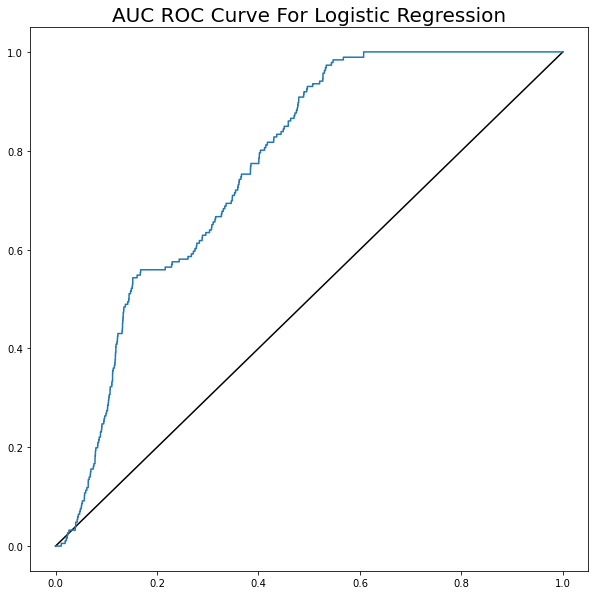

In [219]:
# set plot size
plt.figure(figsize=(10,10))

# create a plot
# idk why some of the examples have like 10 lines of code
# it's literally just this
fpr, tpr, _ = roc_curve(y_valid, valid_2013_preds)

# draw a line. More annoying to figure out than I expected
plt.plot([0,1], [0,1], color = 'k', linestyle = '-')

# add title
plt.title("AUC ROC Curve For Logistic Regression", fontsize = 20)

# plot
plt.plot(fpr, tpr);

### Kaggle Submission
We also need to submit the test scores, so do that here. Apply all the same transformations that we did earlier, this time to the test set

#### Prepare Datasets

In [106]:
# Load it in
test_all = pd.read_csv("../data/test_combined.csv")
test_all.drop(["Unnamed: 0"], inplace=True, axis = 1)
test_all.head(2)

Id        Date                                            Address  Block  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   

            Street  Trap             AddressNumberAndStreet  Latitude  \
0   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469   
1   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL  41.95469   

   Longitude  AddressAccuracy  Year  Month  Day          Unix  Tmax  Tmin  \
0 -87.800991                9  2008      6   11  1.213114e+09  86.0  63.5   
1 -87.800991                9  2008      6   11  1.213114e+09  86.0  63.5   

   Tavg  DewPoint  WetBulb  SnowFall  PrecipTotal  AvgSpeed  \
0  75.0      55.5     64.0       0.0          0.0      10.2   
1  75.0      55.5     64.0       0.0          0.0      10.2   

   Species_CULEX ERRATICUS  Species_CULEX PIPIENS  \
0                        0                      0   
1                        0                      0   

   Species_CULEX PIPIENS/RESTUANS  Species_CULEX RESTUANS  \
0                               1                       0   
1                               0                       1   

   Species_CULEX SALINARIUS  Species_CULEX TARSALIS  Species_CULEX TERRITANS  \
0                         0                       0                        0   
1                         0                       0                        0   

   Species_UNSPECIFIED CULEX  
0                          0  
1                          0

In [107]:
%%time
# Drop the ID column
test_all.drop(["Id"], axis = 1, inplace = True)

# Convert the unix column into seconds after the start of year
test_all = test_all.apply(secs_after_year_start, axis = 1)

# dummy the trap variables
test_all = pd.concat([test_all,
                      pd.get_dummies(test_all["Trap"])], axis = 1)

# change date to the index
test_all["Date"] = pd.to_datetime(test_all["Date"])

test_all.set_index("Date", inplace=True)

Wall time: 1min 12s


Drop cols that are in only test or only train

In [112]:
# check that all columns match exactly (it has to, for reordering of columns)
set(test_all.columns).symmetric_difference(set(train_df_updated.columns))

{'NumMosquitos', 'WnvPresent', 'after_spray', 'wnv_percent'}

This makes sense, these are all variables that we were using in EDA and come from our target variable so the test data doesn't have it.

In [113]:
# copy it to a new variable, it's easier
train_updated_copy = train_df_updated.drop(["NumMosquitos", "after_spray", "wnv_percent"],
                       axis = 1)

In [114]:
# get the target variable
y_train_copy_all = train_updated_copy["WnvPresent"]

In [115]:
# drop the target variable from the X values
# drop it from the copied version! Don't drop it from the original
# If not it's annoying to re-run the whole code
train_updated_copy.drop(["WnvPresent"], axis = 1, inplace= True)

In [116]:
# Reorder the columns so that the model does't get them mixed up:
test_all = test_all[train_updated_copy.columns]

In [117]:
# check that order is exactly the same
# if it's the same, nothing will print
# except 'WNV Present' as that is the target variable
for test, train in zip(list(test_all.columns), list(train_updated_copy.columns)):
    if test != train:
        print("incorrect")
        print(test)
        print(train)

Now that our columns match exactly, and are in the same order, we will be able to fit our linear regression models. However, we will also drop all unnecessary columns before going any further:

In [119]:
test_all.head(2)

Address  Block  \
Date                                                                   
2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   
2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...     41   

                     Street  Trap             AddressNumberAndStreet  \
Date                                                                   
2008-06-11   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL   
2008-06-11   N OAK PARK AVE  T002  4100  N OAK PARK AVE, Chicago, IL   

            Latitude  Longitude  AddressAccuracy  Year  Month  Day  \
Date                                                                 
2008-06-11  41.95469 -87.800991                9  2008      6   11   
2008-06-11  41.95469 -87.800991                9  2008      6   11   

                    Unix  Tmax  Tmin  Tavg  DewPoint  WetBulb  SnowFall  \
Date                                                                      
2008-06-11  1.213114e+09  86.0  63.5  75.0      55.5     64.0       0.0   
2008-06-11  1.213114e+09  86.0  63.5  75.0      55.5     64.0       0.0   

            PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
Date                                                         
2008-06-11          0.0      10.2                        0   
2008-06-11          0.0      10.2                        0   

            Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2008-06-11                      0                               1   
2008-06-11                      0                               0   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2008-06-11                       0                         0   
2008-06-11                       1                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  \
Date                                                          
2008-06-11                       0                        0   
2008-06-11                       0                        0   

            Species_UNSPECIFIED CULEX  T001  T002  T002A  T002B  T003  T004  \
Date                                                                          
2008-06-11                          0     0     1      0      0     0     0   
2008-06-11                          0     0     1      0      0     0     0   

            T005  T006  T007  T008  T009  T009a  T011  T012  T013  T014  T015  \
Date                                                                            
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   

            T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  T034  \
Date                                                                           
2008-06-11     0     0     0     0     0     0     0     0     0     0     0   
2008-06-11     0     0     0     0     0     0     0     0     0     0     0   

            T035  T035a  T036  T037  T039  T040  T043  T044  T045  T046  T047  \
Date                                                                            
2008-06-11     0      0     0     0     0     0     0     0     0     0     0   
2008-06-11     0      0     0     0     0     0     0     0     0     0     0   

            T048  T049  T050  T051  T054  T054C  T060  T061  T062  T063  T065  \
Date                                                                            
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   

            T065A  T066  T067  T069  T070  T071  T072  T073  T074  T075  T076  \
Date                                                                            
2008-06-11      0     0     0     0     0     0     0     0     0     0     0   
20

In [120]:
# unnecessary columns:
# all non-numeric
# year, month, day, address accuracy, block, unix time (it's encoded as a different column)

cols_to_drop = ["Year", "Month", "Day", "Unix", "AddressAccuracy", "Block"]

test_all = test_all._get_numeric_data().drop(cols_to_drop, axis = 1)
train_updated_copy = train_updated_copy._get_numeric_data().drop(cols_to_drop, axis = 1)

In [121]:
# check the order of columns is the same
# it should, but just to be sure
for test, train in zip(list(test_all.columns), list(train_updated_copy.columns)):
    if test != train:
        print("incorrect")
        print(test)
        print(train)

At this point, we can start training models and using them to predict the data for Kaggle. To reiterate, for 2008 predictions we will only use 2007 data as that is what was available at the time. For 2010 we will use both 2007 and 2009, and so on.

In [122]:
# We also want to split the target variable! So I will add it to back to the dataframe
# before splitting it. It should go at the end.
train_updated_copy["WnvPresent"] = y_train_copy_all

In [123]:
# if you scroll to the end, it should be there
train_updated_copy.head(1)

Latitude  Longitude  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
Date                                                                   
2007-05-29  41.95469 -87.800991  88.0  62.5  75.5      58.5     65.5   

            SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
Date                                                                   
2007-05-29       0.0          0.0      6.95                        0   

            Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2007-05-29                      0                               1   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2007-05-29                       0                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  \
Date                                                          
2007-05-29                       0                        0   

            Species_UNSPECIFIED CULEX  T001  T002  T002A  T002B  T003  T004  \
Date                                                                          
2007-05-29                          0     0     1      0      0     0     0   

            T005  T006  T007  T008  T009  T009a  T011  T012  T013  T014  T015  \
Date                                                                            
2007-05-29     0     0     0     0     0      0     0     0     0     0     0   

            T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  T034  \
Date                                                                           
2007-05-29     0     0     0     0     0     0     0     0     0     0     0   

            T035  T035a  T036  T037  T039  T040  T043  T044  T045  T046  T047  \
Date                                                                            
2007-05-29     0      0     0     0     0     0     0     0     0     0     0   

            T048  T049  T050  T051  T054  T054C  T060  T061  T062  T063  T065  \
Date                                                                            
2007-05-29     0     0     0     0     0      0     0     0     0     0     0   

            T065A  T066  T067  T069  T070  T071  T072  T073  T074  T075  T076  \
Date                                                                            
2007-05-29      0     0     0     0     0     0     0     0     0     0     0   

            T077  T078  T079  T080  T081  T082  T083  T084  T085  T086  T088  \
Date                                                                           
2007-05-29     0     0     0     0     0     0     0     0     0     0     0   

            T089  T090  T090A  T090B  T090C  T091  T092  T094  T094B  T095  \
Date                                                                         
2007-05-29     0     0      0      0      0     0     0     0      0     0   

            T096  T097  T099  T100  T102  T103  T107  T114  T115  T128  T128A  \
Date                                                                            
2007-05-29     0     0     0     0     0     0     0     0     0     0      0   

            T129  T135  T138  T141  T142  T143  T144  T145  T146  T147  T148  \
Date                                                                           
2007-05-29     0     0     0     0     0     0     0     0     0     0     0   

            T149  T150  T151  T152  T153  T154  T155  T156  T157  T158  T159  \
Date                                                                           
2007-05-29     0     0     0     0     0     0     0     0     0     0     0   

            T160  T161  T162  T200  T200A  T200B  T206  T209  T212  T215  \
Date                                                                       
2007-05-29     0     0     0     0      0      0     0     0     0     0   

            T218  T218A  T218B  T218C  T219  T220  T221  T222  T223  T224  \
Date                    

In [124]:
# split the training data into 4 categories
# note that 2011 contains 2007, 2009, 2011, same pattern for the others
# once again, save this as a new version.
train_2007_new = train_updated_copy["2007"]
train_2009_new = pd.concat([train_updated_copy["2009"], train_2007_new], axis = 0)
train_2011_new = pd.concat([train_updated_copy["2011"], train_2009_new], axis = 0)
train_2013_new = pd.concat([train_updated_copy["2013"], train_2011_new], axis = 0)

In [125]:
# check that the test data is in ascending order
# it should, but just check
# If it is ascending we can just combine them later on by simply concatenating
test_all.index.is_monotonic_increasing

True

In [126]:
# split the test data into 4 years
test_2008 = test_all["2008"]
test_2010 = test_all["2010"]
test_2012 = test_all["2012"]
test_2014 = test_all["2014"]

In [127]:
# check that it works
print(test_2008.shape)
print(test_2010.shape)
print(test_2012.shape)
print(test_2014.shape)

(30498, 170)
(36557, 170)
(27115, 170)
(22123, 170)


In [139]:
test_2008.head()

Latitude  Longitude  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
Date                                                                   
2008-06-11  41.95469 -87.800991  86.0  63.5  75.0      55.5     64.0   
2008-06-11  41.95469 -87.800991  86.0  63.5  75.0      55.5     64.0   
2008-06-11  41.95469 -87.800991  86.0  63.5  75.0      55.5     64.0   
2008-06-11  41.95469 -87.800991  86.0  63.5  75.0      55.5     64.0   
2008-06-11  41.95469 -87.800991  86.0  63.5  75.0      55.5     64.0   

            SnowFall  PrecipTotal  AvgSpeed  Species_CULEX ERRATICUS  \
Date                                                                   
2008-06-11       0.0          0.0      10.2                        0   
2008-06-11       0.0          0.0      10.2                        0   
2008-06-11       0.0          0.0      10.2                        0   
2008-06-11       0.0          0.0      10.2                        0   
2008-06-11       0.0          0.0      10.2                        0   

            Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2008-06-11                      0                               1   
2008-06-11                      0                               0   
2008-06-11                      1                               0   
2008-06-11                      0                               0   
2008-06-11                      0                               0   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2008-06-11                       0                         0   
2008-06-11                       1                         0   
2008-06-11                       0                         0   
2008-06-11                       0                         1   
2008-06-11                       0                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  \
Date                                                          
2008-06-11                       0                        0   
2008-06-11                       0                        0   
2008-06-11                       0                        0   
2008-06-11                       0                        0   
2008-06-11                       0                        1   

            Species_UNSPECIFIED CULEX  T001  T002  T002A  T002B  T003  T004  \
Date                                                                          
2008-06-11                          0     0     1      0      0     0     0   
2008-06-11                          0     0     1      0      0     0     0   
2008-06-11                          0     0     1      0      0     0     0   
2008-06-11                          0     0     1      0      0     0     0   
2008-06-11                          0     0     1      0      0     0     0   

            T005  T006  T007  T008  T009  T009a  T011  T012  T013  T014  T015  \
Date                                                                            
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   
2008-06-11     0     0     0     0     0      0     0     0     0     0     0   

            T016  T017  T018  T019  T025  T027  T028  T030  T031  T033  T034  \
Date                                                                           
2008-06-11     0     0     0     0     0     0     0     0     0     0     0   
2008-06-11     0     0     0     0     0     0     0     0     0     0     0   
2008-06-11     0     0     0     0     0     0     0     0     0     0     0   
2008-06-11     0     0     0     0     0     0     0     0     0     0     0   
2008-06-11     0     0   

### Model Predictions

We can finally start predicting as we have formatted everything properly.

#### Predict for 2008
Use the data from 2007 to train the model, and predict:

In [136]:
# create pipeline using the best hyperparameters we found above.
# Technically the object already exists so this isn't *necessary*
# but it's easier to read if I just put it here again
# Also I took out the step that gets only numeric data since we have done that already

final_steps = [("august", change_to_august()), #this adds the number of seconds away from Aug 15
         ("scale", StandardScaler()),
         ("logreg", LogisticRegression(C = 0.4, max_iter = 10000))] # best hyperparams from earlier

logistic_pipeline_2007 = Pipeline(final_steps)

In [137]:
# fit to 2007 data only
logistic_pipeline_2007.fit(train_2007_new.drop(["WnvPresent"], axis = 1),
                           train_2007_new["WnvPresent"])

Pipeline(steps=[('august',
                 <__main__.change_to_august object at 0x00000278CD6EAD00>),
                ('scale', StandardScaler()),
                ('logreg', LogisticRegression(C=0.4, max_iter=10000))])

In [149]:
# Predict the values for 2008

# Note: the code works but it shows a warning for some reason
# We know this because the logistic regression has the correct number of columns
# If it had incorrect number of columns it would give an error.

# Also use a different threshold than 50%, using the custom function scale_1D_probas that was
# defined above
preds_2008 = scale_1D_probas(logistic_pipeline_2007.predict_proba(test_2008)[:,1])

<ipython-input-99-b6b81cbdf840>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_from_july"] = np.abs(df["secs_after_jan1"] - july_time)
<ipython-input-99-b6b81cbdf840>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_after_jan1"] = np.abs(df["secs_after_jan1"] - aug_time)


In [150]:
len(preds_2008)

30498

#### Predict for 2010

For 2010 predictions, use data from only 2007 and 2009.

Again, it gives the error. However, it is working.

Note: I know it's working because the line that is giving the error is one that adds an additional column to the dataframe. If it didn't add in the column the logistic regression would cause an error. 

In [151]:
%%time
# new pipeline obj (same params though)
logistic_pipeline_2009 = Pipeline(final_steps)

# fit on train
logistic_pipeline_2009.fit(train_2009_new.drop(["WnvPresent"], axis = 1),
                           train_2009_new["WnvPresent"])

# predict with model, then change threshold with our function
preds_2010 = scale_1D_probas(logistic_pipeline_2009.predict_proba(test_2010)[:,1])
len(preds_2010)

Wall time: 1.45 s


<ipython-input-99-b6b81cbdf840>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_from_july"] = np.abs(df["secs_after_jan1"] - july_time)
<ipython-input-99-b6b81cbdf840>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_after_jan1"] = np.abs(df["secs_after_jan1"] - aug_time)


36557

#### Predict for 2012 and 2014

For 2012 predictions, use data from only 2007, 2009 and 2011. For 2014 predictions, use all data.

In [152]:
%%time
# 2011 data
logistic_pipeline_2011 = Pipeline(final_steps)

# fit on training data up to 2011
logistic_pipeline_2011.fit(train_2011_new.drop(["WnvPresent"], axis = 1),
                           train_2011_new["WnvPresent"])

# predict for 2012
preds_2012 = scale_1D_probas(logistic_pipeline_2011.predict_proba(test_2012)[:,1])
print(len(preds_2012))


# 2013 data
logistic_pipeline_2013 = Pipeline(final_steps)

# fit on training data up to 2013
logistic_pipeline_2013.fit(train_2013_new.drop(["WnvPresent"], axis = 1),
                           train_2013_new["WnvPresent"])

# predict for 2014
preds_2014 = scale_1D_probas(logistic_pipeline_2013.predict_proba(test_2014)[:,1])
len(preds_2014)


<ipython-input-99-b6b81cbdf840>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_from_july"] = np.abs(df["secs_after_jan1"] - july_time)
<ipython-input-99-b6b81cbdf840>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_after_jan1"] = np.abs(df["secs_after_jan1"] - aug_time)


27115
Wall time: 3.98 s


<ipython-input-99-b6b81cbdf840>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_from_july"] = np.abs(df["secs_after_jan1"] - july_time)
<ipython-input-99-b6b81cbdf840>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["secs_after_jan1"] = np.abs(df["secs_after_jan1"] - aug_time)


22123

In [153]:
# Finally, combine all the predictions into one big dataframe.
# As they are sequential, I can just stack them one on top of the other
# instead of having to mess with the indices (which is very annoying)
all_test_preds = preds_2008 + preds_2010 + preds_2012 + preds_2014

In [155]:
# to Dataframe
all_test_preds = pd.DataFrame(all_test_preds)

In [156]:
all_test_preds

0
0       0.321146
1       0.038267
2       0.395408
3       0.001562
4       0.001562
...          ...
116288  0.000011
116289  0.000011
116290  0.000011
116291  0.000011
116292  0.000011

[116293 rows x 1 columns]

#### Submit to Kaggle

In [157]:
# Finally, put it into a form that Kaggle accepts
all_test_preds["Id"] = all_test_preds.index
all_test_preds["Id"] = all_test_preds["Id"] + 1
all_test_preds.head(3)

0  Id
0  0.321146   1
1  0.038267   2
2  0.395408   3

In [160]:
# rename the columns and change the order
all_test_preds = all_test_preds.rename({0 : "WnvPresent"}, axis = 1)
all_test_preds = all_test_preds[["Id", "WnvPresent"]]
all_test_preds.head(2)

Id  WnvPresent
0   1    0.321146
1   2    0.038267

In [161]:
# save to CSV
all_test_preds.to_csv("../data/final_kaggle_predictions.csv", index = False)

![](../assets/Final_Kaggle_Score.png)

This is our final score from Kaggle, about a 10% improvement from our baseline model.

### Conclusions

<img src="../assets/num of mos trapped across year by month.png" width="800">

From our logistic regression model, the single most important factor to predicting the presence of WNV was time. To be more specific, relative time from our hypothesised peak of August. The further the time period is from August, the less the incidence of observing WNV. This is likely also because the mosquito population is smaller as per our EDA findings.

<img src="../assets/Probability of species with virus.png" width="700">

The next most important factor is the type of mosquito species, most notably Culex Pipiens and Restuans. These species appear to be the greatest carrier of the WNV. Temperature and humidity are also important factors to consider. Snowfall and average wind speeds were among the top predictors for the presence of the WNV. Finally, location is also important. Hotspots are bound by proximity and the mosquitoes are only vectors for the WNV that is spread when the mosquito takes the blood of a person already infected with the WNV. Thus, certain traps are top predictors for WNV as they indicate the hotspots.

<img src="../assets/location trap and spray all year.png" width="700">

Based on the above conclusion, we make the following **recommedations**:
- Spraying should be done before and up till August each year. Both EDA and our model suggest that the mosquito population and mosquito carrying virus tends to peak before August. Therefore, spraying would be most effective if it was done before August. After August, the mosquito population begins to dwindle.
- There might be value to studying the genetic make up of species Culex Pipiens and Restuans, and to manufacture spraying chemicals that could more effectively target Culex Pipiens and Restuans as they are the greatest carrier of the virus.
- Our model has revealed that the greater the snowfall, the less likely that WNV will be present. Areas/periods that had snowed will have a lower priority for spraying. The budget for spraying can be saved for when WNV will be/going to be most prevalent.
- During periods that with greater average wind speeds (and therefore less humid), incidence of WNV goes up. Intervention is recommended during these periods, but the efficacy of spraying on a windy day has to be studied further.
- Areas in the vicinity of traps T900 and T225 will need to be more thoroughly sprayed as these traps observed the greatest incidence of WNV-carrying mosquitoes.
<br>
<br>
<br>
<center><sup>--end--<sup/><center>